In [1]:
import pickle
import random
import networkx as nx
import numpy as np
import polars as pl
from nx_landmarks import landmarks

In [2]:
G = nx.read_adjlist('Data/com-dblp_ungraph.csv')
G = nx.convert_node_labels_to_integers(G)

In [3]:
G.number_of_nodes()

317080

In [ ]:
from copy import deepcopy
landmarks_arr = [
    landmarks(G,10,['rand'],1),
    landmarks(G,2, [('deg',(1/3)), ('close',(1/3)), ('between',(1/3))]),
    landmarks(G,2, [('close',(1/2)), ('between',(1/2))]),
    landmarks(G,10,['deg'],1),
    landmarks(G,10,['close'],1),
    landmarks(G,10,['between'],1)
]
print('Done...')
pickle.dump(landmarks_arr, open('data.pkl', 'wb'))
for D in landmarks_arr:
    D.get_landmarks()
original_arr = [deepcopy(D) for D in landmarks_arr]

In [ ]:
def sample_random_pairs(G,n = 1):
    choice = np.random.choice(G.nodes(),2*n)
    pairs =[]
    for i in range(n):
        idx = 2*i
        pairs.append(((choice[idx]),choice[idx+1]))
    return pairs

def average_error(D,pairs,true):
    estimations = []
    for pair in pairs:
        estimations.append(D.shortest_path_estimation_upper_bound(pair[0],pair[1]))
    errors = [(e-t)/t for e,t in zip(estimations,true)]
    return sum(errors)/len(errors)

def average_LU_ratio(D,pairs):
    ratio = []
    for pair in pairs:
        ratio.append(D.shortest_path_estimation_lower_bound(pair[0],pair[1])/D.shortest_path_estimation_upper_bound(pair[0],pair[1]))
    return np.average(np.array(ratio))

In [ ]:
def experiment_setup(G,landmarks:list)->list:
    node_sample = sample_random_pairs(G, 2000)
    true = [nx.shortest_path_length(G, source=s,target=t) for s,t in node_sample]
    results_rel_error = [[] for D in landmarks]
    results_lu_ratio = [[] for D in landmarks]
    
    for n_landm in tqdm(range(50,500,10)):
        for idx,D in enumerate(landmarks):
            results_rel_error[idx].append((average_error(D,node_sample,true),len(D.landmarks)))
            results_lu_ratio[idx].append((average_LU_ratio(D,node_sample),len(D.landmarks)))
            D.add_landmarks(10)
    return results_rel_error,results_lu_ratio

In [ ]:
results_rel_error,results_lu_ratio = experiment_setup(G,original_arr)

100%|██████████| 45/45 [11:32<00:00, 15.40s/it]


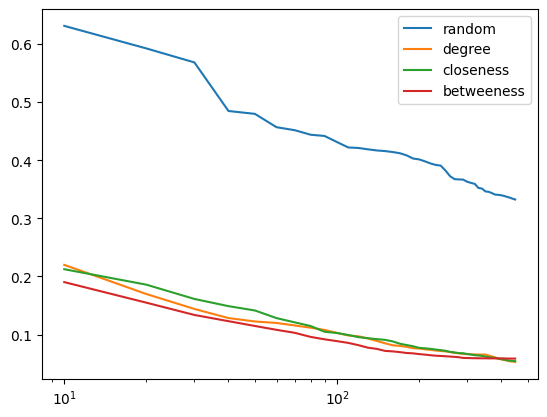

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
x = [a[1] for a in results_rel_error[0]]
y = [a[0] for a in results_rel_error[0]]
ax.plot(x,y, label = 'Mixed (deg,close,between)')
x = [a[1] for a in results_rel_error[1]]
y = [a[0] for a in results_rel_error[1]]
ax.plot(x,y, label = 'Mixed (close,between)')
x = [a[1] for a in results_rel_error[2]]
y = [a[0] for a in results_rel_error[2]]
ax.plot(x,y, label = 'random')
x = [a[1] for a in results_rel_error[3]]
y = [a[0] for a in results_rel_error[3]]
ax.plot(x,y, label = 'degree')
x = [a[1] for a in results_rel_error[4]]
y = [a[0] for a in results_rel_error[4]]
ax.plot(x,y, label = 'closeness')
x = [a[1] for a in results_rel_error[5]]
y = [a[0] for a in results_rel_error[5]]
ax.plot(x,y, label = 'betweeness')

ax.set_xscale('log')
ax.legend()
plt.show()

In [ ]:
min(results_rel_error[3])

(0.058651857864357865, 450)